In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
d = pd.read_csv("sample_clean.csv")
rnlabel = "variability amplitude $R_\mathrm{per}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = 'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'

## McQuillan searched sample

In [5]:
dm14 = pd.read_csv("sample_M14_searched.csv")

In [6]:
from scipy.interpolate import interp1d
dprec = pd.read_csv("data/kepler_precision.txt", delim_whitespace=True)
kepsigma = interp1d(dprec.kepmag, dprec.long, kind='cubic')

In [7]:
params_all = {"robreak": 0.84, "Rbreak": 1.08e4, "bsat": -0.04, "bunsat": -2.61, "lnrsigma": 0.55}
params_mag = {"robreak": 0.99, "Rbreak": 9.7e3, "bsat": -0.02, "bunsat": -4.55, "lnrsigma": 0.59}

In [8]:
tau_g98 = lambda teff: 314.24 * np.exp(-(teff/1952.5)-(teff/6250.)**18) + 0.002

def rper_ro(ro, p, scatter=False):
    ro = np.atleast_1d(ro)
    ret = (ro/p['robreak'])**p['bsat']
    idx = ro > p['robreak']
    ret[idx] = (ro[idx]/p['robreak'])**p['bunsat']
    if not scatter:
        return ret * p['Rbreak']
    else:
        lnR = np.log(ret * p['Rbreak']) + np.random.randn(len(ret))*p['lnrsigma']
        return np.exp(lnR)

def ro_threshold(mags, params, sigma_th=3.):
    magarr = np.atleast_1d(mags)
    magarr = np.where(magarr < 7, 7, magarr)
    ros = np.linspace(0, 10, 10000)
    rpers = rper_ro(ros, params)
    rper_th = sigma_th * kepsigma(magarr)
    return ros[np.argmin(np.abs(rpers[:,None] - rper_th[None,:]), axis=0)]

In [9]:
mags = np.linspace(5, 18, 1000)
rocut_all = interp1d(mags, ro_threshold(mags, params_all))
rocut_mag = interp1d(mags, ro_threshold(mags, params_mag))

def pdetfunc(ros):
    rocuts = np.array(ros)
    return interp1d(np.r_[-np.inf, np.sort(rocuts), np.inf], np.r_[1, np.cumsum(rocuts)[::-1]/np.cumsum(rocuts)[-1], 0.], kind='linear')

In [10]:
dm14['rocut_all'] = rocut_all(dm14.kepmag)
dm14['rocut_mag'] = rocut_mag(dm14.kepmag)

In [11]:
pdet_all = pdetfunc(dm14.rocut_all)
pdet_mag = pdetfunc(dm14.rocut_mag)

### teff -> mass, bp-rp

In [22]:
diso = pd.read_csv("data/MIST_1e8yr.txt", comment='#', delim_whitespace=True)
diso['bprp'] = diso['Gaia_BP_DR2Rev'] - diso['Gaia_RP_DR2Rev']
print (diso.keys())

Index(['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass',
       'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U',
       'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J',
       '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp',
       'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev',
       'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 'Gaia_BP_MAWb', 'Gaia_BP_MAWf',
       'Gaia_RP_MAW', 'TESS', 'Gaia_G_EDR3', 'Gaia_BP_EDR3', 'Gaia_RP_EDR3',
       'phase', 'bprp'],
      dtype='object')


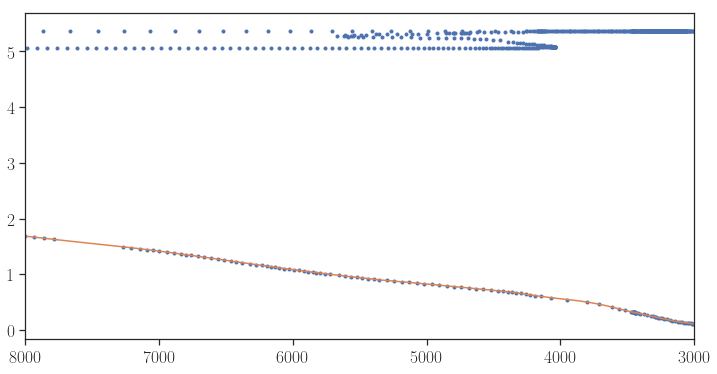

In [23]:
idxm3 = diso.initial_mass < 3
teff2mass = interp1d(10**(diso.log_Teff[idxm3]), diso.initial_mass[idxm3], kind='cubic')
x = np.linspace(3000, 8000, 100)
#plt.ylim(8000, )
plt.xlim(8000, 3000)
plt.plot(10**diso.log_Teff, diso.initial_mass, '.')
plt.plot(x, teff2mass(x))

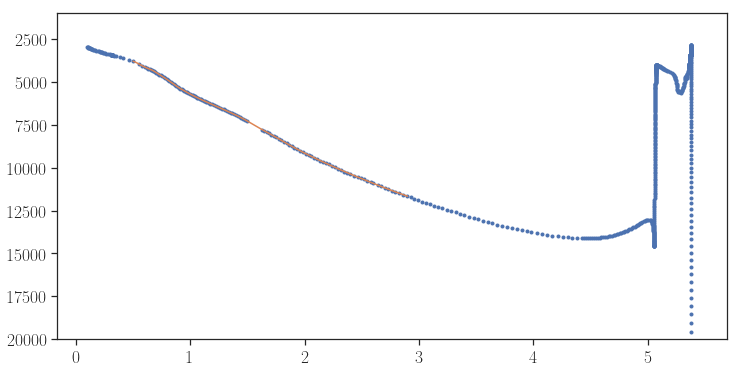

In [36]:
idxm3 = diso.initial_mass < 3
mass2teff = interp1d(diso.initial_mass[idxm3], 10**(diso.log_Teff[idxm3]), kind='cubic')
x = np.linspace(0.5, 2.9, 100)
#plt.ylim(8000, )
plt.ylim(20000, 1000)
plt.plot(diso.initial_mass, 10**diso.log_Teff, '.')
plt.plot(x, mass2teff(x))

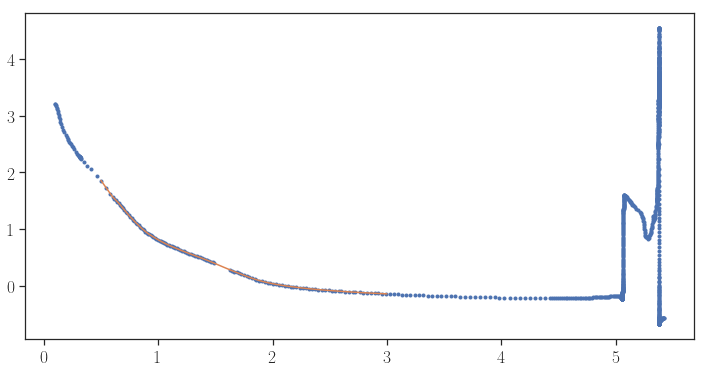

In [37]:
idxm3 = diso.initial_mass < 3.1
mass2bprp = interp1d(diso.initial_mass[idxm3], diso.bprp[idxm3], kind='cubic')
x = np.linspace(0.5, 3)
#plt.ylim(0, 3)
plt.plot(diso.initial_mass, diso.bprp, '.')
plt.plot(x, mass2bprp(x))

In [38]:
resdir = "detection_age/"

In [39]:
dm14['mass'] = teff2mass(dm14.teff)
dm14['bprp'] = mass2bprp(dm14.mass)

In [40]:
def convective_overturn_time(mass):
    logm = np.log10(mass)
    logtau = 1.16 - 1.49 * logm - 0.54 * logm * logm
    return 10**logtau

def gyro_model_praesepe(logage, bprp, mass, Ro_cutoff=2):
    # Angus+19 table 1
    # c4, c3, c2, c1, c0, cA, b1, b0
    p = [-38.957586198640314, 28.709418579540294, -4.919056437046026,
         0.7161114835620975, -4.716819674578521, 0.6470950862322454,
         -13.558898318835137, 0.9359250478865809]
    logprot = np.where(bprp < 0.56, 0.56, np.polyval(p[:5], np.log10(bprp)) + p[5]*logage)

    tau = convective_overturn_time(mass)
    logpmax = np.log10(Ro_cutoff * tau)
    Ro = 10**logprot / tau
    logprot = np.where((Ro >= Ro_cutoff) & (bprp >= 0.56), logpmax, logprot)

    return 10**logprot

In [41]:
def ros_from_ages(ages, mass, Ro_cutoff=2.):
    logage = np.log10(ages*1e9)
    bprp, teff = mass2bprp(mass), mass2teff(mass)
    prot = gyro_model_praesepe(logage, bprp, mass, Ro_cutoff=Ro_cutoff)
    return prot, prot / tau_g98(teff)

age_upper = lambda mass: -30 * (mass-1.25) + 5.

In [42]:
ml, mu = 0.95, 1.05

In [43]:
resdir

'detection_age/'

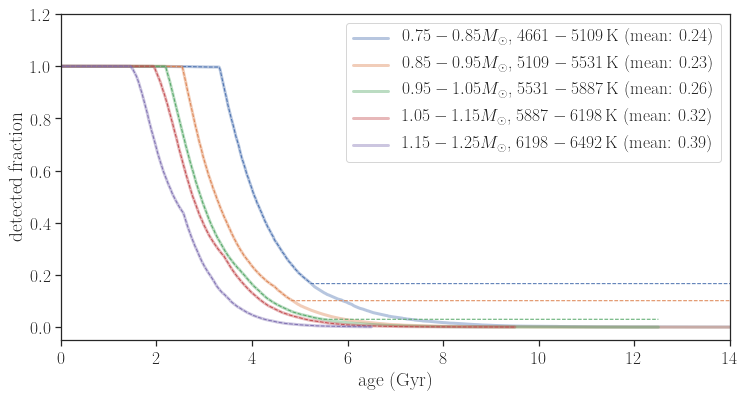

In [44]:
plt.xlim(0, 14.)
plt.ylim(-0.05, 1.2)
for i,m in enumerate([0.8, 0.9, 1, 1.1, 1.2]):
    ages = np.linspace(0, age_upper(m), 1000)
    prots, ros = ros_from_ages(ages, m, Ro_cutoff=100.)
    prots2, ros2 = ros_from_ages(ages, m, Ro_cutoff=2.)
    
    ml, mu = m-0.05, m+0.05
    tl, tu = mass2teff([ml, mu])
    rocuts = rocut_mag(np.array(dm14.kepmag[(tl<dm14.teff)&(dm14.teff<tu)]))
    pdet = pdetfunc(rocuts)
    
    plt.xlabel("age (Gyr)")
    plt.ylabel("detected fraction")
    #plt.plot(ages, pdet_mag(ros), ls='solid', lw=1.)
    plt.plot(ages, pdet(ros), ls='solid', lw=3, color='C%d'%i, alpha=0.4,
             label='$%.2f-%.2fM_\odot$, $%d-%d\,\mathrm{K}$ (mean: %.2f)'%(ml,mu,tl,tu,np.mean(pdet(ros))))
    plt.plot(ages, pdet(ros2), ls='dashed', lw=1, color='C%d'%i,)
            # label='$%.2f-%.2fM_\odot$, $%d-%d\,\mathrm{K}$ (mean: %.2f)'%(ml,mu,tl,tu,np.mean(pdet(ros))))
plt.legend(loc='best')
plt.savefig(resdir+"pdet_age.png", dpi=200, bbox_inches="tight")

In [45]:
d = pd.read_csv("sample_clean.csv")

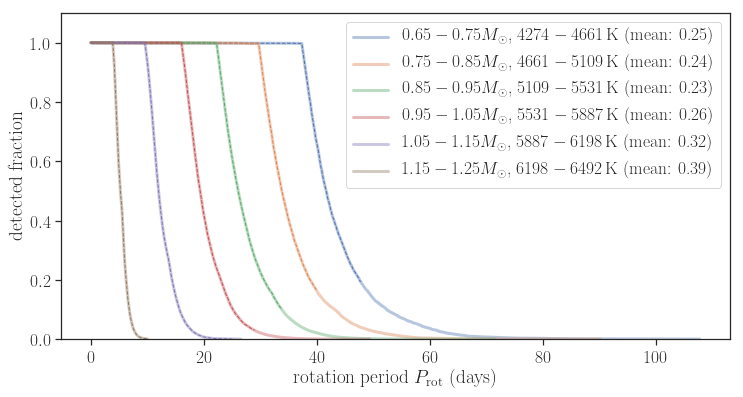

In [46]:
teffs, p10s, p10d = [], [], []
plt.ylim(0.0, 1.1)
#plt.yscale("log")
for i,m in enumerate([0.7, 0.8, 0.9, 1, 1.1, 1.2]):
    ages = np.linspace(0, age_upper(m), 1000)
    prots, ros = ros_from_ages(ages, m, Ro_cutoff=100.)
    prots2, ros2 = ros_from_ages(ages, m, Ro_cutoff=2.)
    
    ml, mu = m-0.05, m+0.05
    tl, tu = mass2teff([ml, mu])
    rocuts = rocut_mag(np.array(dm14.kepmag[(tl<dm14.teff)&(dm14.teff<tu)]))
    pdet = pdetfunc(rocuts)
    
    plt.xlabel(protlabel)
    plt.ylabel("detected fraction")
    plt.plot(prots, pdet(ros), ls='solid', lw=3., color='C%d'%i, alpha=0.4,
             label='$%.2f-%.2fM_\odot$, $%d-%d\,\mathrm{K}$ (mean: %.2f)'%(ml,mu,tl,tu,np.mean(pdet(ros))))
    plt.plot(prots2, pdet(ros2), ls='dashed', lw=1., color='C%d'%i)
            # label='$%.2f-%.2fM_\odot$, $%d-%d\,\mathrm{K}$ (mean: %.2f)'%(ml,mu,tl,tu,np.mean(pdet(ros))))
        
    ps = pdet(ros)
    p10s.append(prots2[np.argmin(np.abs(ps-0.1))])
    teffs.append(0.5*(tl+tu))
    p10d.append(np.percentile(d.Prot[(tl<d.teff)&(d.teff<tu)], 80.))
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.savefig(resdir+"pdet_prot.png", dpi=200, bbox_inches="tight")

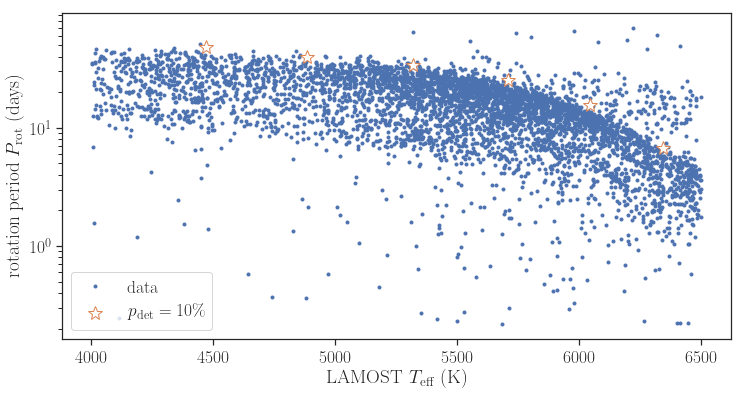

In [47]:
plt.yscale("log")
plt.xlabel(tefflabel)
plt.ylabel(protlabel)
plt.plot(d.teff, d.Prot, '.', label='data')
#plt.plot(teffs, p10d, 'o', markersize=15, mfc='white')
plt.plot(teffs, p10s, '*', markersize=15, mfc='white', label='$p_\mathrm{det}=10\%$')
plt.legend()
plt.savefig(resdir+"pdet10_prot_teff.png", dpi=200, bbox_inches="tight")

### Is WMB essential?

In [82]:
def simulate(d, Ro_crit=2.):
    ages = np.random.rand(len(d)) * age_upper(d.mass)
    prots, ros = ros_from_ages(ages, d.mass, Ro_cutoff=Ro_crit)
    d['Prot'] = prots
    d['Ro'] = ros
    return d

In [106]:
dsim = simulate(dm14, Ro_crit=10.)

In [107]:
np.sum(idxd) / len(dsim)

0.28289343287526425

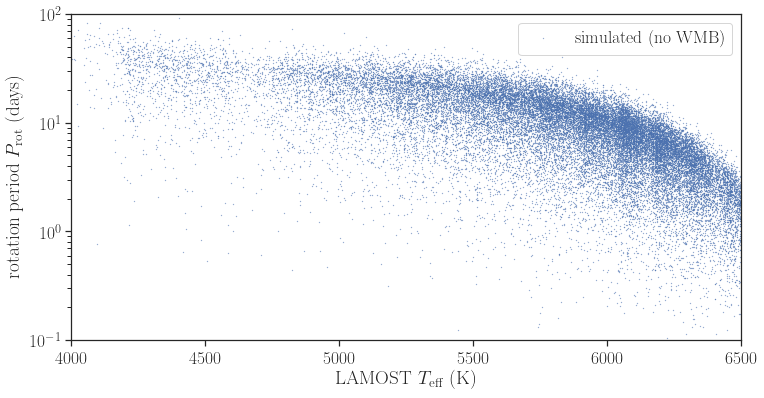

In [114]:
plt.xlim(4000, 6500)
plt.ylim(0.1, 100)
plt.yscale("log")
plt.xlabel(tefflabel)
plt.ylabel(protlabel)
#plt.plot(dsim.teff, dsim.Prot, ',', label='simulated')
#idxd = dsim.Ro < dsim['rocut_all']
#plt.plot(dsim.teff[idxd], dsim.Prot[idxd], '.', label='simulated (all)')
idxd = (dsim.Ro < dsim['rocut_mag']) #& (dsim.kepmag<14.)
plt.plot(dsim.teff[idxd], dsim.Prot[idxd], '.', label='simulated (no WMB)', markersize=0.5)
#plt.plot(d.teff, d.Prot, '.', label='data', color='gray', mfc='none', lw=0.1)
plt.legend()

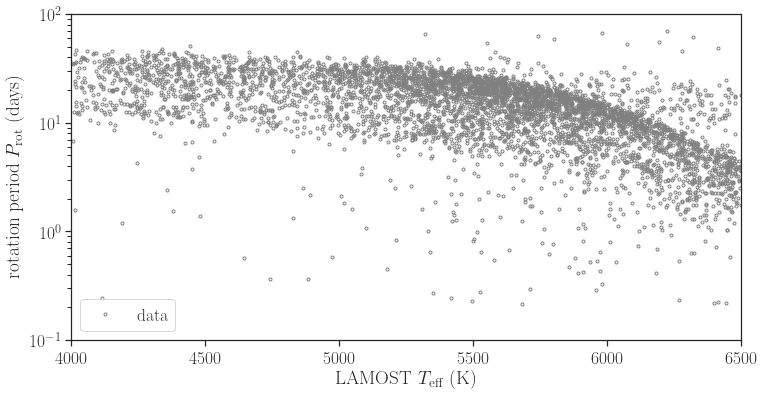

In [111]:
plt.xlim(4000, 6500)
plt.ylim(0.1, 100)
plt.yscale("log")
plt.xlabel(tefflabel)
plt.ylabel(protlabel)
#idxd = dsim.Ro < dsim['rocut_mag']
#plt.plot(dsim.teff[idxd], dsim.Prot[idxd], '.', label='simulated (mag)', markersize=1)
plt.plot(d.teff, d.Prot, '.', label='data', color='gray', mfc='none', lw=0.1)
plt.legend()